In [ ]:
import torch
from heat_solver import HeatSolver
from inverse_solver import InverseSolver
from utils import (
    create_conductivity_field,
    sine_source,
    sine_cosine_source,
    relative_rmse,
    r2_score,
)
from IPython.display import clear_output
from utils import SimpleSigma, SigmoidSigma, compare

import numpy as np

In [3]:
device = "cpu"

## Omega experiment

In [4]:
from matplotlib import pyplot as plt
from tqdm import tqdm


def experiment(
    sigma_gt,
    source_func,
    noise_level=0.05,
    max_iters=100,
    alpha=0.001,
    lr=1e-2,
    T=1.0,
    sigma_0=1.0,
    max_sigma=5.0,
    device: str = "cpu",
):
    M = sigma_gt.shape[0]
    assert sigma_gt.shape[0] == sigma_gt.shape[1]

    # Generate boundary observations with noise
    solver = HeatSolver(M, source_func, device)
    _, u_gt_b_history, u_gt_history = solver(sigma_gt, T, max_sigma=max_sigma)
    u_gt_b_noisy_history = (
        1 + noise_level * torch.randn_like(u_gt_b_history)
    ) * u_gt_b_history

    del u_gt_b_history

    # Iterate inverse problem solver
    inverse_solver = InverseSolver(
        SimpleSigma(M, sigma_0),
        u_b_gt=u_gt_b_noisy_history,
        source_func=source_func,
        M=M,
        T=T,
        alpha=alpha,
        lr=lr,
        sigma_0=sigma_0,
        device=device,
    )

    fig, ax = plt.subplots(1, 1)
    data_loss_history = []
    reg_loss_history = []
    total_loss_history = []
    for data_term, reg_term, total_loss in tqdm(
        inverse_solver.solve(max_iters=max_iters), total=max_iters
    ):
        data_loss_history.append(data_term)
        reg_loss_history.append(reg_term)
        total_loss_history.append(total_loss)

        ax.clear()
        ax.set_title("Loss")
        ax.plot(data_loss_history, label="Data loss", alpha=0.8)
        ax.plot(reg_loss_history, label="Reg loss", alpha=0.8)
        ax.plot(total_loss_history, label="Total loss", alpha=0.8)
        ax.legend()
        ax.set_yscale("log")
        clear_output(wait=True)
        display(fig)

    res_sigma = inverse_solver.get_solution()

    print("Running full simulation with resulting sigma")
    _, _, u_history = solver(res_sigma, T, max_sigma=max_sigma)

    # 1. Assess sigma_gt vs res_sigma
    compare(u_history, u_gt_history, source_func, solver.tau)

  0%|          | 0/100 [00:04<?, ?it/s]


NameError: name 'clear_output' is not defined

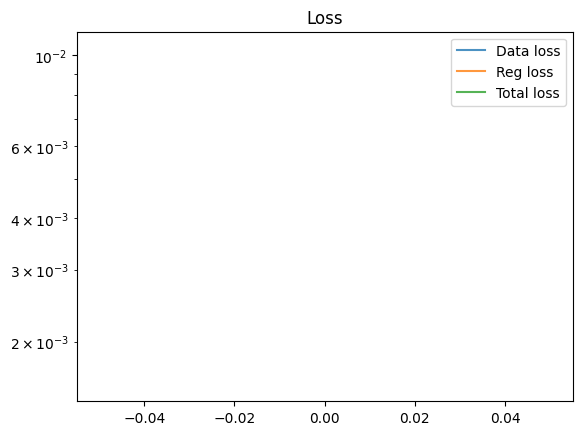

In [5]:
omega = 0.3
sincos10_source = lambda x, y, t: 10 * sine_cosine_source(x, y, t, omega, device)
sigma_gt = create_conductivity_field(pattern="constant", device=device)
experiment(sigma_gt, sincos10_source)

# $\alpha$ experiment

In [ ]:
M = 10
T = 1.0
device = "cpu"
max_sigma = 5
omega = 2 * np.pi
alpha_arr = np.array([1e-4, 1e-3, 1e-2, 1e-1, 1])
sigma_0 = 1.0  # Initial guess
lr = 1e-1
noise_level = 0.05
max_iters = 5000
tol = 1e-1
pattern = "linear"

source_func = lambda x, y, t: 10 * sine_cosine_source(x, y, t, omega)
sigma_gt = create_conductivity_field(M, pattern=pattern, device=device)

In [ ]:
relative_mse_arr = []

for i, alpha in enumerate(alpha_arr):
    print(f"Optimizing sigma for alpha={alpha:.3f}")

    # Generate boundary observations with noise
    u_b_gt = get_boundary_conditions(sigma_gt, source_func, T, max_sigma, device=device)
    u_b = (1 + noise_level * torch.randn_like(u_b_gt)) * u_b_gt

    sigma_module = SimpleSigma(M, sigma_0)

    # Inverse solver
    inverse_solver = InverseSolver(
        sigma_module,
        u_b_gt=u_b,
        source_func=source_func,
        M=M,
        T=T,
        n_steps=u_b.shape[0] - 1,
        alpha=alpha,
        sigma_0=sigma_0,
        device=device,
    )

    (
        final_sigma,
        total_loss_history,
        boundary_loss_history,
        regularization_loss_history,
    ) = inverse_solver.solve(max_iters=max_iters, tol=tol, print_info=False)

    mse_arr.append(r2_score(final_sigma, sigma_gt))

In [ ]:
plt.plot(alpha_arr, mse_arr)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$R^2$ score")
plt.xscale("log")
plt.show()

# Transformations of $\sigma$ experiment

In [ ]:
M = 10
T = 1.0
device = "cpu"
max_sigma = 5
omega = 2 * np.pi
alpha_arr = 0.0001
sigma_0 = 1.0  # Initial guess
lr = 1e-1
noise_level = 0.05
max_iters = 5000
tol = 1e-1
pattern = "linear"

source_func = lambda x, y, t: 10 * sine_cosine_source(x, y, t, omega)
sigma_gt = create_conductivity_field(M, pattern=pattern, device=device)

sigma_modules = [SimpleSigma, SigmoidSigma]

In [ ]:
relative_mse_arr = []

for i, sigma_module in enumerate(sigma_modules):
    print(f"Optimizing sigma {i+1}/2")

    # Generate boundary observations with noise
    u_b_gt = get_boundary_conditions(sigma_gt, source_func, T, max_sigma, device=device)
    u_b = (1 + noise_level * torch.randn_like(u_b_gt)) * u_b_gt

    # Inverse solver
    inverse_solver = InverseSolver(
        sigma_module,
        u_b_gt=u_b,
        source_func=source_func,
        M=M,
        T=T,
        n_steps=u_b.shape[0] - 1,
        alpha=alpha,
        sigma_0=sigma_0,
        device=device,
    )

    (
        final_sigma,
        total_loss_history,
        boundary_loss_history,
        regularization_loss_history,
    ) = inverse_solver.solve(max_iters=max_iters, tol=tol, print_info=False)

    mse_arr.append(r2_score(final_sigma, sigma_gt))

# Noise level experiment

In [ ]:
M = 10
T = 1.0
device = "cpu"
max_sigma = 5
omega = 2 * np.pi
alpha_arr = 0.0001
sigma_0 = 1.0  # Initial guess
lr = 1e-1
noise_level_arr = np.array([1e-3, 0.01, 0.05, 0.1])
max_iters = 5000
tol = 1e-1
pattern = "linear"

source_func = lambda x, y, t: 10 * sine_cosine_source(x, y, t, omega)
sigma_gt = create_conductivity_field(M, pattern=pattern, device=device)

In [ ]:
relative_mse_arr = []

for i, noise_level in enumerate(noise_level_arr):
    print(f"Optimizing sigma for noise_level={noise_level:.3f}")

    # Generate boundary observations with noise
    u_b_gt = get_boundary_conditions(sigma_gt, source_func, T, max_sigma, device=device)
    u_b = (1 + noise_level * torch.randn_like(u_b_gt)) * u_b_gt

    sigma_module = SimpleSigma(M, sigma_0)

    # Inverse solver
    inverse_solver = InverseSolver(
        sigma_module,
        u_b_gt=u_b,
        source_func=source_func,
        M=M,
        T=T,
        n_steps=u_b.shape[0] - 1,
        alpha=alpha,
        sigma_0=sigma_0,
        device=device,
    )

    (
        final_sigma,
        total_loss_history,
        boundary_loss_history,
        regularization_loss_history,
    ) = inverse_solver.solve(max_iters=max_iters, tol=tol, print_info=False)

    mse_arr.append(r2_score(final_sigma, sigma_gt))

In [ ]:
plt.plot(noise_level_arr, mse_arr)
plt.xlabel("Noise level")
plt.ylabel(r"$R^2$ score")
plt.show()